# Stage 3 - HackBio Internship: Neuroscience and Psychology
## Team Members:
**Chama BENSLIMANE (Leader)**: [GitHub Profile](https://github.com/BenslimaneChama)

**Mohammad HICHAM POLO**: [GitHub Profile](https://github.com/MohammadHichamPolo)


## Project Overview
Here's the approach we followed for this project : 

- Data preprocessing and exploration
- Application of machine learning models for classification
- Biostatistical analysis of relevant factors
- Interpretation of results through markdown explanations and visualizations

Our work consists of 3 parts:
- Data processing 
- training machine, female data with different models 
- training machine, male data with different models 

**In this notebook, we focused on the female dataframe, and performed machine learning with three models: Logistic Regression, Random Forest, and XGBoost, where we tried to select the best features that would let us predict depression.**


*All findings, including statistical interpretations and graph analyses, are documented within this notebook to provide a comprehensive understanding of the methodology and outcomes.*

# Packages Needed

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder
from joblib import Parallel, delayed
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score,roc_curve,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
import shap 


# DATA IMPORTINT AND TREATEMENT

*For further details, please check the first notebook on data processing, treatement and cleaning available on Github.*

In [81]:
df = pd.read_csv('http://raw.githubusercontent.com/HackBio-Internship/2025_project_collection/refs/heads/main/Python/Dataset/Student%20Depression%20Dataset.csv')
df=df.dropna()
df = df.drop(columns=['id'])
df = df[(df['Job Satisfaction'] == 0.0) & (df['Work Pressure'] == 0.0)]
df = df[df['Profession'] == 'Student']
df = df.drop(columns=['Profession'])
df = df.drop(columns=['Job Satisfaction'])
df = df.drop(columns=['Work Pressure'])
valid_cities = [
    'Visakhapatnam', 'Bangalore', 'Srinagar', 'Varanasi', 'Jaipur', 'Pune', 'Thane',
    'Chennai', 'Nagpur', 'Nashik', 'Vadodara', 'Kalyan', 'Rajkot', 'Ahmedabad',
    'Kolkata', 'Mumbai', 'Lucknow', 'Indore', 'Surat', 'Ludhiana', 'Bhopal',
    'Meerut', 'Agra', 'Ghaziabad', 'Hyderabad', 'Vasai-Virar', 'Kanpur', 'Patna',
    'Faridabad', 'Delhi'
]


df = df[df['City'].isin(valid_cities)]

In [82]:
le_city = LabelEncoder()
df['City'] = le_city.fit_transform(df['City'])

# Save the mapping of City names to numbers
city_mapping = dict(zip(le_city.classes_, le_city.transform(le_city.classes_)))
categorical_cols = ['Gender', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']


label_encoders = {}

# Encode each categorical column
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    
    # Store the mapping of labels to numbers
    label_encoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))

sleep_mapping = {
    'Less than 5 hours': 4,
    '5-6 hours': 5.5,
    'Others': 6.5,
    '7-8 hours': 7.5,
    'More than 8 hours': 9
}

df['Sleep Duration'] = df['Sleep Duration'].map(sleep_mapping)

In [83]:
df = df[df['Age'] <= 40]
df = df[df['CGPA'] > 0]

# POTENTIAL PREDICTIVE FEATURES INVISTIGATION USING PCA AND RFE ALONGSIDE A BENCHMARK OF MODEL TRAINING FOR FEMALE

## DATA PREPARATION FOR MACHINE LEARNING

#### CREATING A FUNCTION TO INCLUDE ONLY FEMALES

In [84]:
df_female = df[df["Gender"] == 0]
df_female = df_female.drop(columns=['Gender'])

### Feature Selection and Evaluation of Classification Models for the Prediction of Depression

In [6]:
X = df_female.drop(columns=['Depression'])
Y = df_female["Depression"]

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

def train_rfe_model(model_name, model, num_features, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    accuracy_scores = []
    auc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    mean_fpr = np.linspace(0, 1, 100)  # Standard scale for ROC curves
    tpr_list = []  
    selected_features = None 

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        
        rfe = RFE(model, n_features_to_select=num_features)
        X_train_selected = rfe.fit_transform(X_train, y_train)
        X_test_selected = rfe.transform(X_test)
        
       
        if selected_features is None:
            selected_features = X_train.columns[rfe.support_].tolist()
        
        
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        y_pred_proba = model.predict_proba(X_test_selected)[:, 1]

       
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)
        auc = roc_auc_score(y_test, y_pred_proba)
        auc_scores.append(auc)
        report = classification_report(y_test, y_pred, output_dict=True)
        precision_scores.append(report['weighted avg']['precision'])
        recall_scores.append(report['weighted avg']['recall'])
        f1_scores.append(report['weighted avg']['f1-score'])
        
       
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        tpr_list.append(np.interp(mean_fpr, fpr, tpr))  # Interpolation

    
    return {
        "Model": model_name,
        "Num_Features": num_features,
        "Selected_Features": ", ".join(selected_features),  
        "Accuracy": np.mean(accuracy_scores),
        "AUC": np.mean(auc_scores),
        "Precision": np.mean(precision_scores),
        "Recall": np.mean(recall_scores),
        "F1-Score": np.mean(f1_scores),
        "mean_fpr": np.array(mean_fpr),
        "mean_tpr": np.mean(tpr_list, axis=0),
    }


tasks = [(model_name, model, num_features, X, Y) for model_name, model in models.items() for num_features in range(1, 13)]

results = Parallel(n_jobs=-1, verbose=10)(
    delayed(train_rfe_model)(*task) for task in tasks
)

df_results = pd.DataFrame(results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  36 | elapsed:   13.1s remaining:   39.5s
[Parallel(n_jobs=-1)]: Done  13 out of  36 | elapsed:   30.1s remaining:   53.3s
[Parallel(n_jobs=-1)]: Done  17 out of  36 | elapsed:   41.4s remaining:   46.3s
[Parallel(n_jobs=-1)]: Done  21 out of  36 | elapsed:   45.1s remaining:   32.2s
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed:   52.2s remaining:   22.9s
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:  1.4min remaining:   19.8s
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:  1.8min remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.9min finished


We selected the best features to predict depression using Recursive Feature Elimination (RFE) so that we tested a combination of 1 to X features (here X = 12), then trained several machine learning models: 
**Logistic regression**: Simple, interpretable model for binary classification.
**Random Forest**: Ensemble algorithm based on several decision trees.
**XGBoost**: Powerful ensemble algorithm using boosting.

Models were evaluated using several metrics:
- Accuracy: rate of correct predictions, 
- Are Under Curve ROC (AUC): Area under the ROC curve, which measures the model's ability to classify positive and negative cases,
- Recall, F1-Score, which give more detailed indications of prediction quality.

As a result, we had obtained 36 combinations that were tested in parallel, enabling us to run them quickly in *2.9 minutes* (instead of several hours if we ran each one individually), and then we could check in df_results to really see which model got the best score.

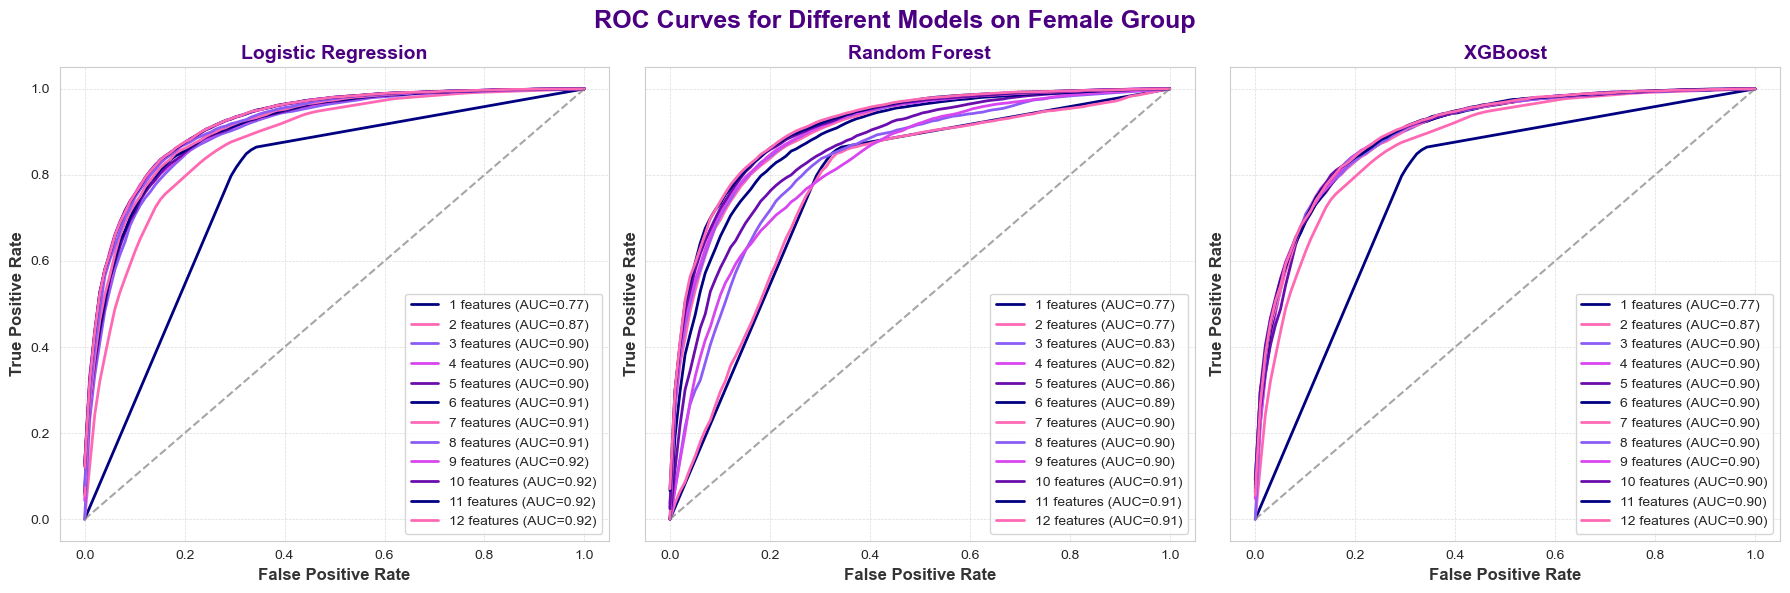

In [7]:

sns.set_style("whitegrid")


custom_palette = ["#6a0dad", "#000080", "#ff69b4", "#8b5cf6", "#d946ef"]


fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)


fig.suptitle("ROC Curves for Different Models on Female Group", fontsize=18, fontweight='bold', color="#4B0082")

# Iterate over the models and corresponding axes
for ax, (model_name, model) in zip(axes, models.items()):
    for num_features in range(1, 14):
        subset = df_results[(df_results["Model"] == model_name) & (df_results["Num_Features"] == num_features)]
        if not subset.empty:
            ax.plot(
                subset["mean_fpr"].values[0], subset["mean_tpr"].values[0], 
                label=f"{num_features} features (AUC={subset['AUC'].values[0]:.2f})",
                color=custom_palette[num_features % len(custom_palette)], linewidth=2
            )

    # Reference line (gray dashed)
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.7)

    
    ax.set_xlabel("False Positive Rate", fontsize=12, fontweight='bold', color="#333333")
    ax.set_ylabel("True Positive Rate", fontsize=12, fontweight='bold', color="#333333")


    ax.set_title(f"{model_name}", fontsize=14, fontweight='bold', color="#4B0082")


    ax.legend(fontsize=10, frameon=True, loc="lower right")

    # Add subtle grid lines
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 1.01])  # Leaves space for the common title
plt.show()

We generated ROC curves for each of the three models we tested, applied to the female group, testing different selections of characteristics.
For each of the three models, the AUC varies from 0.77 to 0.92, but what changes is rather the number of features, and how long it took to reach 0.92 approximately.

- For **Logistic Regression**, with 3 features alone, we've already reached 0.90, and with *10 features*, we've reached the maximum value *(0.92)*.
- For **Random Forest**, it took 7 features to reach 0.90, and even then it never reached the maximum value (0.92).
- Like Logistic Regression, **XGBoost** was able to reach 0.90 with just 3 features, but was never able to reach 0.91 or 0.92.

Our aim is to select the best model capable of predicting depression with the fewest features possible, **so for now, based on AUC, the best: Logistic Regression.**


In [8]:
df_results.to_csv('Female_ML_Benchmark_Results.csv', index=False)
df_results

,Model,Num_Features,Selected_Features,Accuracy,AUC,Precision,Recall,F1-Score,mean_fpr,mean_tpr
0,Logistic Regression,1,Have you ever had suicidal thoughts ?,0.786160,0.771319,0.785384,0.786160,0.783712,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.0, 0.027507768065304094, 0.0550155361306081..."
1,Logistic Regression,2,"Academic Pressure, Have you ever had suicidal ...",0.808819,0.873416,0.808144,0.808819,0.807261,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.0, 0.12302667765816684, 0.2429029138531987,..."
2,Logistic Regression,3,"Academic Pressure, Have you ever had suicidal ...",0.828148,0.898606,0.827747,0.828148,0.826827,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.0, 0.2303957202489169, 0.3340190251734727, ..."
3,Logistic Regression,4,"Academic Pressure, Dietary Habits, Have you ev...",0.832696,0.904147,0.832177,0.832696,0.832108,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.043493070033202075, 0.25872896792806455, 0...."
4,Logistic Regression,5,"Academic Pressure, Dietary Habits, Have you ev...",0.833833,0.904473,0.833234,0.833833,0.833064,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.06489556790981392, 0.2704147772606772, 0.35..."
5,Logistic Regression,6,"Academic Pressure, Study Satisfaction, Dietary...",0.835376,0.906590,0.834798,0.835376,0.834687,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.058781271716469775, 0.26857048010800616, 0...."
6,Logistic Regression,7,"Academic Pressure, Study Satisfaction, Dietary...",0.835458,0.909239,0.834863,0.835458,0.834758,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.05489083854528608, 0.2661146822639179, 0.37..."
7,Logistic Regression,8,"Age, Academic Pressure, Study Satisfaction, Di...",0.840006,0.913843,0.839461,0.840006,0.839365,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.07879536329240985, 0.28306974364913906, 0.3..."
8,Logistic Regression,9,"Age, Academic Pressure, Study Satisfaction, Sl...",0.842362,0.919812,0.841886,0.842362,0.841769,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.12506978225619642, 0.3332382634545595, 0.43..."
9,Logistic Regression,10,"Age, Academic Pressure, CGPA, Study Satisfacti...",0.843823,0.920083,0.843351,0.843823,0.843242,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.12923751061694078, 0.3237879314338661, 0.43..."


This time, based not only on AUC, but also Accuracy, Precision, Recall and F1-Score, we note that :
- The maximum number of features for Logistic Regression that allows us to have the maximum score = 10 features, with Accuracy = 84.38%, AUC = 92%, Precision =84.3%, and F1-Score = 84%.
- For Random Forest = 12 features, with Accuracy = 84%, AUC = 91%, Precision = 84%, F1-Score = 84%.
- For XG-Boost = 3 features, with Accuracy = 83%, AUC = 90%, Precision = 83%, F1-Score = 83%

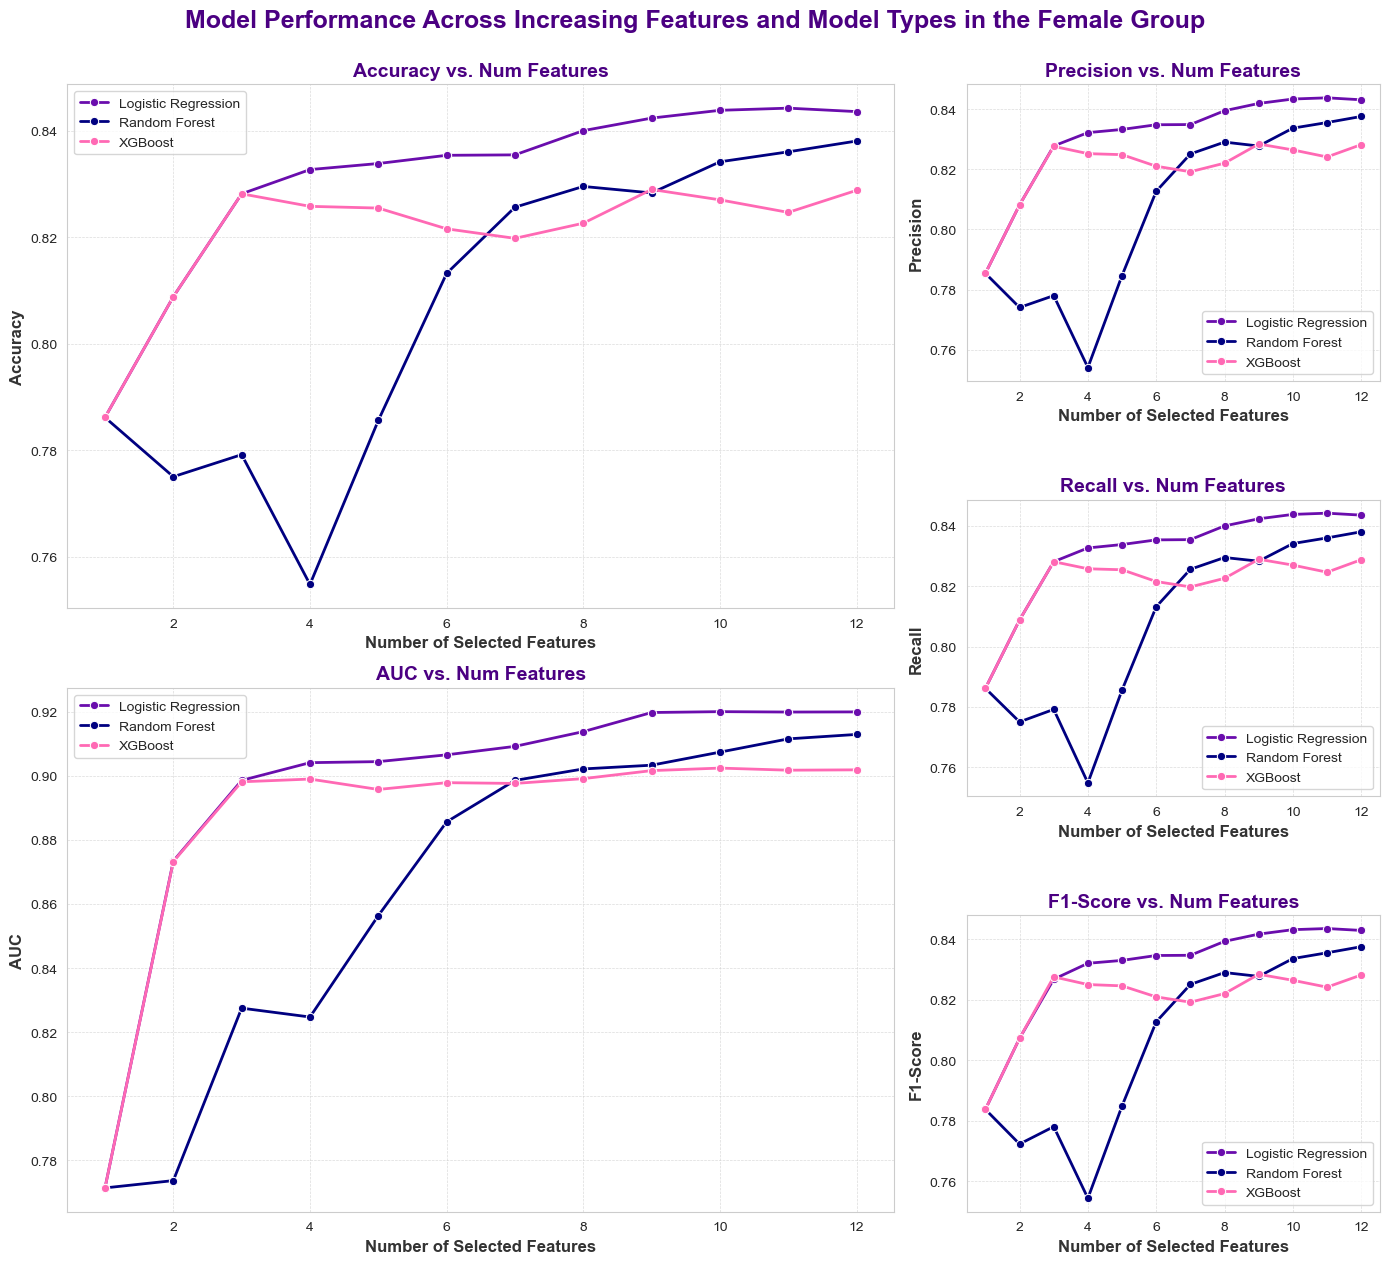

The best model by Accuracy is a Logistic Regression model with 0.8442297753296308 requiring 11 selected features.
The best model by AUC is a Logistic Regression model with 0.9200826503701721 requiring 10 selected features.
The best model by Precision is a Logistic Regression model with 0.8437524980594521 requiring 11 selected features.
The best model by Recall is a Logistic Regression model with 0.8442297753296308 requiring 11 selected features.
The best model by F1-Score is a Logistic Regression model with 0.8436214056327997 requiring 11 selected features.


In [9]:
metrics = ["Accuracy", "AUC", "Precision", "Recall", "F1-Score"]
titles = ["Accuracy vs. Num Features", "AUC vs. Num Features", 
          "Precision vs. Num Features", "Recall vs. Num Features", "F1-Score vs. Num Features"]


sns.set_style("whitegrid")


custom_palette = ["#6a0dad", "#000080", "#ff69b4", "#8b5cf6", "#d946ef"]


fig = plt.figure(figsize=(14, 12))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1]) 

fig.suptitle(
    "Model Performance Across Increasing Features and Model Types in the Female Group",
    fontsize=18, fontweight='bold', color="#4B0082", y=1.05  # Dark purple
)

# Subplot positions
ax1 = fig.add_subplot(gs[0, 0])  # Accuracy (big left-top)
ax2 = fig.add_subplot(gs[1, 0])  # AUC (big left-bottom)

# Create a grid inside the right-side column to stack the three small plots
gs_right = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[:, 1], hspace=0.4)
ax3 = fig.add_subplot(gs_right[0, 0])  # Precision (top-right)
ax4 = fig.add_subplot(gs_right[1, 0])  # Recall (middle-right)
ax5 = fig.add_subplot(gs_right[2, 0])  # F1-Score (bottom-right)

axes = [ax1, ax2, ax3, ax4, ax5]

# Iterate over metrics and axes
for i, metric in enumerate(metrics):
    ax = axes[i]
    
    # Plot each model's performance over the number of features
    for idx, model in enumerate(df_results["Model"].unique()):
        subset = df_results[df_results["Model"] == model]
        sns.lineplot(
            data=subset, x="Num_Features", y=metric, ax=ax, label=model, marker='o',
            color=custom_palette[idx % len(custom_palette)], linewidth=2
        )

    # Set title with improved font
    ax.set_title(titles[i], fontsize=14, fontweight='bold', color="#4B0082")  # Dark purple

    # Set labels with better readability
    ax.set_xlabel("Number of Selected Features", fontsize=12, fontweight='bold', color="#333333")
    ax.set_ylabel(metric, fontsize=12, fontweight='bold', color="#333333")

    # Improve legend
    ax.legend(fontsize=10, frameon=True, loc="best")

    # Enhance grid
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 1.05])  # Leaves space for the big title
plt.show()

for metric in metrics: 
    df_sorted = df_results.sort_values(by=metric, ascending=False)
    model, number,value = df_sorted.iloc[0][["Model", "Num_Features",metric]]
    print(f"The best model by {metric} is a {model} model with {value} requiring {number} selected features.")


From this graph, we can better visualize how Logistic regression outperforms the two remaining models since the 4th selected feature.

In [85]:

def add_model_scores(df):
    
    metrics = ["Accuracy", "AUC", "Precision", "Recall", "F1-Score"]
    for metric in metrics:
        df[f"Norm_{metric}"] = (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())

  
    df["Performance_Score"] = (
        0.2 * df["Norm_Accuracy"] +
        0.15 * df["Norm_AUC"] +
        0.15 * df["Norm_Precision"] +
        0.2 * df["Norm_Recall"] +
        0.3 * df["Norm_F1-Score"]
    )


    max_features = df["Num_Features"].max()
    df["Feature_Penalty"] = df["Num_Features"] / max_features * 0.05  # 5% penalty max

    # Final score calculation
    df["Final_Score"] = df["Performance_Score"] - df["Feature_Penalty"]
    
    return df



df_results = add_model_scores(df_results)

In [11]:
best_models = df_results.loc[df_results.groupby("Model")["Final_Score"].idxmax()]
best_models = best_models.sort_values(by="Final_Score", ascending=False)
best_models

,Model,Num_Features,Selected_Features,Accuracy,AUC,Precision,Recall,F1-Score,mean_fpr,mean_tpr,Norm_Accuracy,Norm_AUC,Norm_Precision,Norm_Recall,Norm_F1-Score,Performance_Score,Feature_Penalty,Final_Score
9,Logistic Regression,10,"Age, Academic Pressure, CGPA, Study Satisfacti...",0.843823,0.920083,0.843351,0.843823,0.843242,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.12923751061694078, 0.3237879314338661, 0.43...",0.995455,1.000000,0.995524,0.995455,0.995748,0.996235,0.041667,0.954568
23,Random Forest,12,"Age, City, Academic Pressure, CGPA, Study Sati...",0.838057,0.912968,0.837554,0.838057,0.837601,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.07058431781329627, 0.29962705387595356, 0.4...",0.930970,0.952173,0.930894,0.930970,0.932608,0.934630,0.050000,0.884630
26,XGBoost,3,"Academic Pressure, Have you ever had suicidal ...",0.828148,0.898168,0.827617,0.828148,0.827619,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.0, 0.2226576250108217, 0.33383524015299554,...",0.820149,0.852689,0.820102,0.820149,0.820861,0.825237,0.012500,0.812737


We calculated a final score for each model by normalizing their performance (Accuracy, AUC, Precision, Recall, F1-Score) and applying a penalty according to the number of features used.
### **1. Normalization of Metrics**  
$$
\text{Norm\_Metric} = \frac{\text{Metric} - \min(\text{Metric})}{\max(\text{Metric}) - \min(\text{Metric})}
$$

### **2. Performance Score Calculation**  
$$
\text{Performance\_Score} = 0.2 \times \text{Norm\_Accuracy} + 0.15 \times \text{Norm\_AUC} + 0.15 \times \text{Norm\_Precision} + 0.2 \times \text{Norm\_Recall} + 0.3 \times \text{Norm\_F1-Score}
$$

### **3. Final Score Calculation (with Feature Penalty)**  
$$
\text{Final\_Score} = \text{Performance\_Score} - \left( \frac{\text{Num\_Features}}{\max(\text{Num\_Features})} \times 0.05 \right)
$$

When no penalty is applied, the Logistic Regression model with 11 features is considered the best, achieving a score of 0.999877.


However, once a penalty based on the number of features used is applied, the score is adjusted by arbitrarily subtracting 0.05 for every unit of the ratio between the number of selected features and the total possible features.


The best models are ranked according to this final score:

1st : Logistic Regression (Final Score = 0.954593)

- With Optimal number of features = 10
- Advantages: Excellent overall performance, good interpretability
- Disadvantages: Slightly penalized for its number of features

2nd: Random Forest (Final Score = 0.892351)
- Optimal number of features: 11
- Advantages: Good robustness and ability to capture complex relationships
- Disadvantages: Highly penalized by the use of 12 features

3rd: XGBoost (Final Score = 0.813727)
- Optimal number of features: only 3!
- Advantages: Very efficient with few features (less penalized)
- Disadvantages: Less efficient than Logistic Regression and Random Forest in terms of AUC and Accuracy.

Final choice: Logistic Regression for robustness and interpretability, XGBoost for a simple model with few variables.

In [12]:
best_models.iloc[0]["Selected_Features"]

'Age, Academic Pressure, CGPA, Study Satisfaction, Sleep Duration, Dietary Habits, Have you ever had suicidal thoughts ?, Work/Study Hours, Financial Stress, Family History of Mental Illness'

Top 10 features selected: 
Age, 
Academic pressure, 
CGPA, 
Satisfaction with studies, 
Sleep duration, Eating habits, 
Have you ever had suicidal thoughts? 
Work/study hours, 
Financial stress, 
Family history of mental illness.

In [13]:
single_feature_row = df_results[df_results["Num_Features"] == 1]
single_feature_row["Selected_Features"].unique()

array(['Have you ever had suicidal thoughts ?'], dtype=object)

Top 1 features = Suicidal thoughts

In [86]:

X = df_female.drop(columns=["Depression"])
y = df_female["Depression"]


# Feature Selection with RFE (Selects 10 Best Features)
logreg = LogisticRegression(max_iter=1000)
rfe = RFE(logreg, n_features_to_select=10)
X_rfe = rfe.fit_transform(X, y)


X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, random_state=42)


model = LogisticRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)


print(f"Model Accuracy: {accuracy * 100:.2f}%")

report = classification_report(y_test, y_pred)


print("\nClassification Report:")
print(report)

Model Accuracy: 83.96%

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1036
           1       0.85      0.88      0.86      1427

    accuracy                           0.84      2463
   macro avg       0.84      0.83      0.83      2463
weighted avg       0.84      0.84      0.84      2463



We then calculated the accuracy of these selected models and obtained = 83.96%.

Which is a very good percentage 

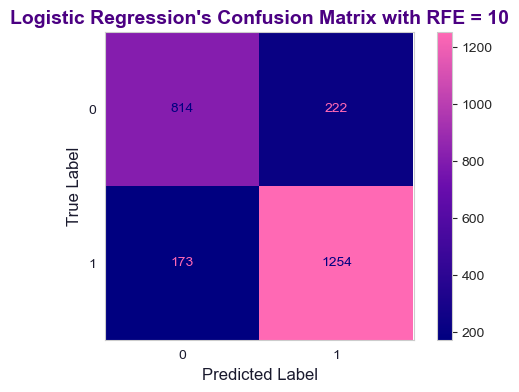

In [87]:
# Define Colors
text_color = "#1a1a2e"  # Dark text
highlight_color = "#6a5acd"  # Slate Blue for title

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 4))  # Keep background white



# Custom colormap blending Navy Blue, Deep Purple, and Bright Pink
custom_cmap = LinearSegmentedColormap.from_list("chroma", ["#000080", "#6a0dad", "#ff69b4"])  

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=custom_cmap, ax=ax, colorbar=True)  # Pass colormap & remove colorbar if not needed
ax.grid(False)  # Remove grid lines

# Customize Appearance
plt.title("Logistic Regression's Confusion Matrix with RFE = 10", fontsize=14, fontweight="bold", color="#4B0082")
plt.xlabel("Predicted Label", fontsize=12, color=text_color)
plt.ylabel("True Label", fontsize=12, color=text_color)
plt.xticks(color=text_color)
plt.yticks(color=text_color)

# Show Plot
plt.show()

# Selected Features analysis
This SHAP summary plot represents the impact of various features on a machine learning model's predictions for depression in the female group. The SHAP (SHapley Additive exPlanations) values indicate how much each feature contributes to either increasing or decreasing the likelihood of depression. The x-axis represents the SHAP values, where negative values suggest a lower probability of depression, while positive values indicate a higher probability. The y-axis lists the features, ranked by their importance in the model’s predictions.
The color gradient, from dark blue to pink, helps us see whether higher or lower values of each factor increase or decrease the likelihood of depression.

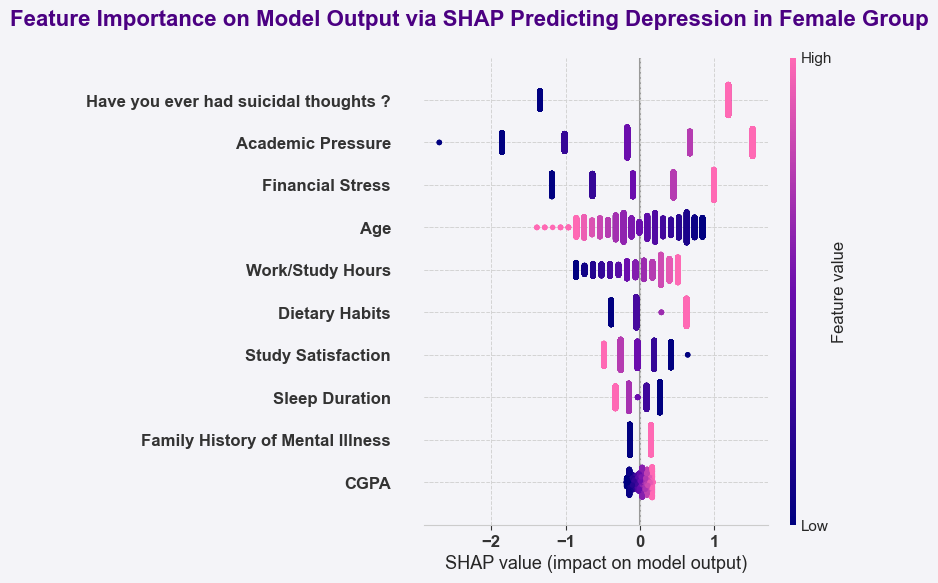

In [88]:



sns.set_style("whitegrid")


background_color = "#f4f4f8"  # Light gray background
title_color = "#4B0082"  # Indigo title


selected_features = X.columns[rfe.get_support()]

# Create SHAP explainer
explainer = shap.Explainer(model, X_rfe)
shap_values = explainer(X_rfe)

# Create a custom colormap (Navy Blue → Purple → Pink)
custom_colors = ["#000080", "#6a0dad", "#ff69b4"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)


plt.figure(figsize=(12, 6), facecolor=background_color)

shap.summary_plot(shap_values, X_rfe, feature_names=selected_features, cmap=custom_cmap, show=False)

plt.suptitle(
    "Feature Importance on Model Output via SHAP Predicting Depression in Female Group",
    fontsize=16, fontweight="bold", color=title_color, 
    x=0.5, ha="center", y=1.05
)
plt.xticks(fontsize=12, fontweight='bold', color="#333333")
plt.yticks(fontsize=12, fontweight='bold', color="#333333")
plt.gca().set_facecolor(background_color)
plt.grid(color="lightgray", linestyle="--", linewidth=0.7)

plt.show()

### **Female Students:**
- **Suicidal Thoughts:**  
  *What do you think?* Suicidal thoughts are the strongest predictor of depression. When RFE = 1, they contribute (0.786160 + 0.786160 + 0.786160) / 3 to the model performance for female students. Check the pink dots on the graph – they indicate students who have had suicidal thoughts and are more likely to be classified as depressed. Have you observed this in your environment?  
  **Key Insight:** Having suicidal thoughts is a significant red flag for mental health struggles. 

- **Academic Pressure:**  
  *Do you feel the pressure?* Students experiencing high academic stress (shown by the pink dots) tend to have a higher risk of depression. How do you think academic expectations affect your well-being?  
  **Key Insight:** Academic stress plays a major role, but it’s not the only factor. 

- **Financial Stress:**  
  *How does money affect you?* Financial worries (represented by pink dots) are closely linked to depression. Do you think financial stability plays a role in mental health?  
  **Key Insight:** Financial stress can significantly affect mental health, adding to the pressure of academic life.

- **Age:**  
  *Do you feel your age impacting your mental health?* Age doesn’t show a clear pattern for depression, but it likely interacts with other factors. How do you think your life stage impacts how you handle stress?  
  **Key Insight:** Age is a complex factor and doesn’t have a one-size-fits-all relationship with depression. 

- **Work or Study Hours:**  
  *How many hours do you spend working or studying?* Overworking can lead to burnout, but some students handle long hours better than others. What about you – do you think work hours affect your mental health?  
  **Key Insight:** The impact of work and study hours depends on personal coping skills and support systems.

- **Diet and Study Satisfaction:**  
  *Are you happy with your studies?* Students who enjoy their studies (represented by pink dots on the left) tend to be less depressed. How does studying something you like affect your mood?  
  **Key Insight:** Enjoying what you study can help buffer against mental health struggles.

- **Sleep Duration:**  
  *How well do you sleep?* Students who sleep less (blue dots) are at a higher risk of depression. What’s your sleep pattern like, and how do you think it affects your mood?  
  **Key Insight:** Good sleep is a strong protective factor for mental health.

- **Family History of Mental Illness:**  
  *Does your family history affect you?* Those with a family history (pink dots) are slightly more likely to develop depression, but it's not a definitive factor. What’s your perspective on the role of family history in mental health?  
  **Key Insight:** A family history may increase risk, but many other factors are at play.

- **CGPA (Grade Point Average):**  
  *How much do grades affect you?* Surprisingly, CGPA seems to have the least impact on depression. How much do you think academic performance affects your mental health?  
  **Key Insight:** Grades are less important in predicting depression than stress-related factors like finances or academic pressure.
